In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import glob
from matplotlib.animation import FuncAnimation
import os
from scipy.io import loadmat
import math
import pandas as pd
from scipy.signal import butter,filtfilt, lfilter
from scipy import signal
from scipy.ndimage import convolve1d
from scipy.interpolate import interp1d

## Carico la matrice

In [2]:
patient = '211_01_L_joints'  # nome del file (senza .mat)
# qui metti il path al file .mat sul tuo pc (compreso .mat)
data = loadmat(
    r"/home/davide/Documents/FESI/Labo/Pazienti/"+patient+".mat")
data_filter = data[list(data.keys())[-1]]


Do' un'occhiata ai grafici

In [3]:
print(data_filter)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


Ci sono parecchi nan, vado a levare solo quelli agli estremi così dopo posso completare i valori mancanti all'interno dei grafici

In [4]:
#funzione per levare nan agli estremi
def nanRem(arr):
    start, end = 0, len(arr)-1
    while(np.isnan(arr[start])):
        start+=1
    while(np.isnan(arr[end])):
        end-=1
    newarray = np.array(arr[start:end])
    return newarray
        

In [5]:
anca_x = nanRem(data_filter[:,0])
anca_y = nanRem(data_filter[:,1])
ginocchio_x = nanRem(data_filter[:,2])
ginocchio_y = nanRem(data_filter[:,3])
caviglia_x = nanRem(data_filter[:,4])
caviglia_y = nanRem(data_filter[:,5])
piede_x = nanRem(data_filter[:,6])
piede_y = nanRem(data_filter[:,7])

segnali=[anca_x, anca_y, ginocchio_x, ginocchio_y, caviglia_x, caviglia_y, piede_x, piede_y]
#fare la trasposta

Dopo aver diviso in liste le coordinate x e y di ogni punto e dopo aver levato i nan vado a plottare

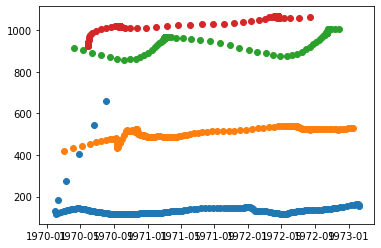

In [6]:
for i in (0,2,4,6):
    plt.plot_date(segnali[i], segnali[i+1])

Oltre al fatto che il grafico è rovesciato, ci sono anche delle interferenze.

# Inverto l'asse y:

Semplicemente prendo ogni valore degli array contenenti le y e lo sottraggo al valore massimo globale 

In [7]:
def invAsseY(segnale, massimo):
    return (massimo-segnale)

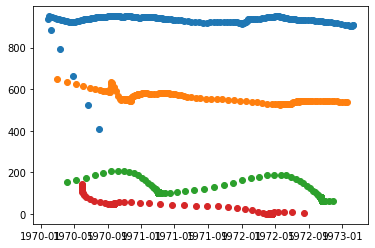

In [8]:
massimo = max(np.nanmax(anca_y), np.nanmax(ginocchio_y), np.nanmax(caviglia_y), np.nanmax(piede_y))

segnali=[anca_x, massimo-anca_y, ginocchio_x, massimo-ginocchio_y, caviglia_x, massimo-caviglia_y, piede_x, massimo-piede_y]

for i in (0,2,4,6):
    plt.plot_date(segnali[i], segnali[i+1])

plt.show()

# Correggo le interferenze con dei filtri

Prendo come esempio i valori x dell'anca per far vedere come operano i filtri plottando i risultati intermedi.

## Interpolazione

Interpolo i valori mancanti sostituendo i nan.

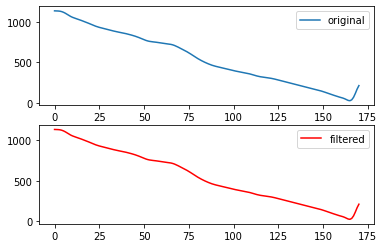

In [9]:
res=pd.Series(anca_x).interpolate(method='polynomial', order=2)

plt.figure()
plt.subplot(211)
plt.plot(anca_x)
plt.legend(['original'])
#plt.title('original')
plt.subplot(212)

plt.plot(res, 'r')
plt.legend(['filtered'])
plt.show()

## Passa-basso

Applico un filtro passa-basso con frequenza 12Hz poichè il corpo umano non riesce a muoversi a questa frequenza e quindi i dati rilevati saranno sicuramente disturbi.

Faccio la trasformata di Fourier del mio segnale:

(-1.0, 100000.0)

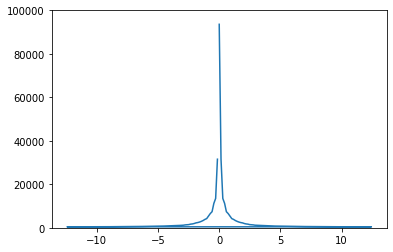

In [10]:
fs = 25
fft_f = np.fft.fft(res)
n = len(fft_f)
freq = np.fft.fftfreq(n, 1/fs)

plt.plot(freq,np.abs(fft_f))  
plt.ylim([-1,100000])

Applico il filtro levando le frequenze maggiori di 12Hz

(-1.0, 100000.0)

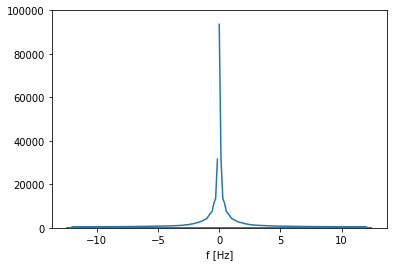

In [11]:
idx = np.argwhere(np.abs(freq)>12)
fft_cut=np.copy(fft_f)
fft_cut[idx]=0

plt.plot(freq,np.abs(fft_cut) )
plt.xlabel('f [Hz]')
plt.ylim([-1,100000])

Applico una trasformata di Furier inversa e plotto il segnale risultante

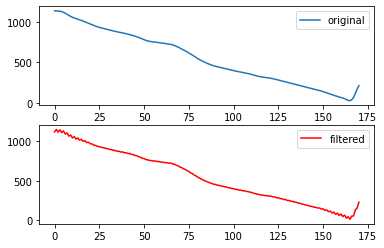

In [12]:
f_cut=np.fft.ifft(fft_cut)

plt.figure()
plt.subplot(211)
plt.plot(res)
plt.legend(['original'])
#plt.title('original')
plt.subplot(212)

plt.plot(np.real(f_cut),'r')
plt.legend(['filtered'])
plt.show()

## Mediano

Applico infine un filtro mediano per levare eventuali spike localizzati dovuti ad errori nella raccolta dei movimenti

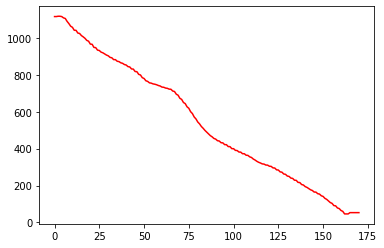

In [13]:
filt_med=signal.medfilt(np.real(f_cut), kernel_size=7) 
plt.plot(filt_med, 'r')

## Gaussiano

Ora applico un filtro gaussiano.

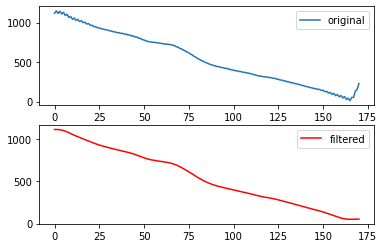

In [14]:
windowg = signal.windows.gaussian(9, std=3) #cambiare valori della gaussian
windowg /= sum(windowg)
filt = convolve1d(filt_med, windowg)

plt.figure()
plt.subplot(211)
plt.plot(np.real(f_cut))
plt.legend(['original'])
plt.subplot(212)
plt.plot(filt, 'r')
plt.legend(['filtered'])
plt.show()

## Filtri applicati sugli altri segnali

Ora faccio le stesse operazioni su tutti gli altri segnali (anca_y , ginocchio_x, ginocchio_y, caviglia_x, caviglia_y, piede_x e piede_y)

In [15]:
for segnale in segnali:
    
    segnale=pd.Series(segnale).interpolate(method='polynomial', order=2)
    
    fs = 25
    fft_f = np.fft.fft(segnale)
    n = len(fft_f)
    freq = np.fft.fftfreq(n, 1/fs)

    idx = np.argwhere(np.abs(freq)>12)
    fft_cut=np.copy(fft_f)
    fft_cut[idx]=0

    f_cut=np.fft.ifft(fft_cut)

    filt_med=signal.medfilt(np.real(f_cut), kernel_size=7) 

    windowg = signal.windows.gaussian(9, std=3)
    windowg /= sum(windowg)
    segnale = convolve1d(filt_med, windowg)

## Plot

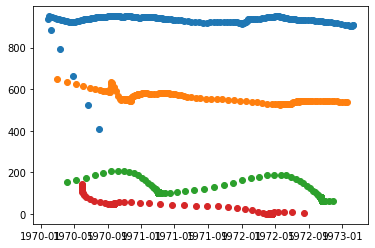

In [16]:
for i in (0, 2, 4, 6):
    segnali[i]=segnali[i][0:segnali[i+1].size]
    segnali[i+1]=segnali[i+1][0:segnali[i].size]
    plt.plot_date(segnali[i], segnali[i+1])

plt.show()

# Gif

Vado a creare una gif per evidenziare i movimenti della gamba nel tempo.

Prima di tutto importo le libreire:

In [17]:
import matplotlib.animation as animation
from IPython import display

Ora inizializzo il grafico:

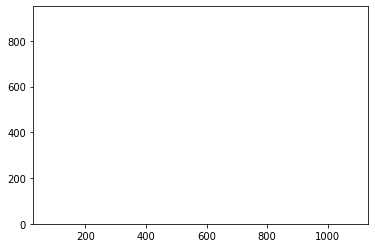

In [18]:
min_x=min(min(segnali[0]),min(segnali[2]),min(segnali[4]),min(segnali[6]))
max_x=max(max(segnali[0]),max(segnali[2]),max(segnali[4]),max(segnali[6]))
min_y=min(min(segnali[1]),min(segnali[3]),min(segnali[5]),min(segnali[7]))
max_y=max(max(segnali[1]),max(segnali[3]),max(segnali[5]),max(segnali[7]))

fig = plt.figure()
axis = plt.axes(xlim = (min_x, max_x),
                ylim = (min_y, max_y))

line, = axis.plot([], [], lw = 2)

In [19]:
def init():
    line.set_data([], [])
    return line,

Creo la funzione che andrà a restituire i singoli punti:

In [20]:
# function takes frame as an input
def animate(frame):
    xdata, ydata = [], []
    for i in (0,2,4,6):
        if(frame<len(segnali[i])):
            x=segnali[i][frame]
            xdata.append(x)
        
           
        if(frame<len(segnali[i+1])):
            y=segnali[i+1][frame]
            ydata.append(y)
        
    line.set_data(xdata, ydata)
    return [line]

In [21]:
def reverseAnimate(frame):
    xdata, ydata = [], []
    for i in (0,2,4,6):
        if(200-frame<len(segnali[i])):
            x=segnali[i][200-frame]
            xdata.append(x)
        
           
        if(200-frame<len(segnali[i+1])):
            y=segnali[i+1][200-frame]
            ydata.append(y)
        
    line.set_data(xdata, ydata)
    return [line]

Ora creo la Gif e la salvo:

In [22]:
%matplotlib notebook
if "R" in patient or "dx" in patient:                     #se nel nome vedo che c'è R o dx printo la gif reversata
    anim = animation.FuncAnimation(fig, reverseAnimate,
                                init_func = init,
                                frames = 200,
                                interval = 20,
                                blit = True)
else:
    anim = animation.FuncAnimation(fig, animate,
                                init_func = init,
                                frames = 200,
                                interval = 20,
                                blit = True)
plt.show()

In [23]:
anim.save('gamba.mp4', writer = 'ffmpeg', fps = 30)


%matplotlib inline

Andiamo ad analizzare la distanza tra i passi:

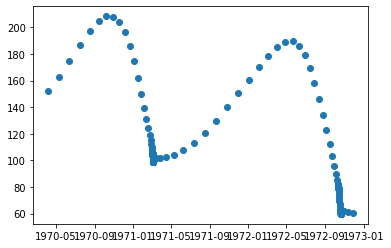

In [31]:
plt.plot_date(segnali[4], segnali[5])
plt.show()

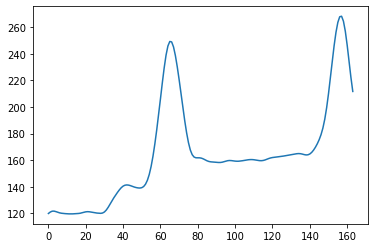

In [32]:
from scipy.signal import find_peaks

arr = -segnali[5]
arr += np.max(arr)
peaks, _ = find_peaks(arr, height=0)
plt.plot(-arr)
plt.plot(peaks, -arr[peaks], "x")
plt.show()